In [1]:
import torch
import cv2
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch
import clip
from PIL import Image
from tqdm import tqdm
import functions as fnc
from importlib import reload
from sklearn.cluster import KMeans
from scipy.ndimage import rotate
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import gc
from skimage.measure import label, regionprops

In [2]:
from segment_anything import SamAutomaticMaskGenerator_mod as SamAutomaticMaskGenerator

In [3]:
OutDIR='/DATA/vito/output/'
DataDIR='/DATA/vito/data/'
MODEL_TYPE = "vit_h"

if torch.cuda.is_available():
    DEVICE = torch.device('cuda:0')
    print('Currently running on GPU\nModel '+MODEL_TYPE)
else:
    DEVICE = torch.device('cpu')
    print('Currently running on CPU\nModel '+MODEL_TYPE)

if MODEL_TYPE == 'vit_h':
    CHECKPOINT_PATH = DataDIR+'MetaSAM/sam_vit_h_4b8939.pth'
elif MODEL_TYPE == 'vit_l':
    CHECKPOINT_PATH = DataDIR+'MetaSAM/sam_vit_l_0b3195.pth'
else:
    CHECKPOINT_PATH = DataDIR+'MetaSAM/sam_vit_b_01ec64.pth'

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

Currently running on GPU
Model vit_h


In [4]:
#fn_img = glob.glob(DataDIR+'test_img/*')
fn_img = glob.glob(DataDIR+'drone_ortho/*')
fn_img.sort()
print('Available images:')
for i, fn in enumerate(fn_img):
    print(f'{i}:' + fn.split("/")[-1])
print("---------------")

Available images:
0:512patched_LaPaya.npy
1:512patched_mask.npy
2:LaPaya_Apr2024_03May24_orthomosaic_5cm_UTM19S_WGS84.tif
3:LaPaya_Apr2024_orthomosaic_5cm_UTM19S_WGS84.tif
4:Ravi1_DEM_0.6mm.tif
5:Ravi1_Orthomosaic_0.2mm.tif
6:Ravi1_orthomosaic_from_DEM_0.6mm.tif
7:Ravi2_Orthomosaic_0.2mm.tif
8:Ravi2_Orthomosaic_0.2mm_clip1.tif
9:Ravi3_Orthomosaic_0.2mm.tif
10:big_clip.tif
11:small_clip1.tif
12:small_clip2.tif
---------------


In [5]:
img_select=int(input("Select a image: "))
image = cv2.imread(fn_img[img_select])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(fn_img[img_select].split("/")[-1]+' imported')
print('Image size:', image.shape)

Ravi2_Orthomosaic_0.2mm_clip1.tif imported
Image size: (2680, 5125, 3)


In [6]:
temp_image=fnc.preprocessing_roulette(image, 
                                      {'Crop': {'j':1},
                                       'Gaussian': {'kernel size':3},
                                       'CLAHE':{'clip limit':3}}
                                       )

In [7]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   


In [8]:
predictor = SamPredictor(sam)
predictor.set_image(temp_image)

In [9]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
    return_logits=True,
)

In [10]:
np.unique(logits[0])

array([-18.622684, -18.341381, -18.251064, ...,   8.411978,   8.44395 ,
         9.688116], dtype=float32)

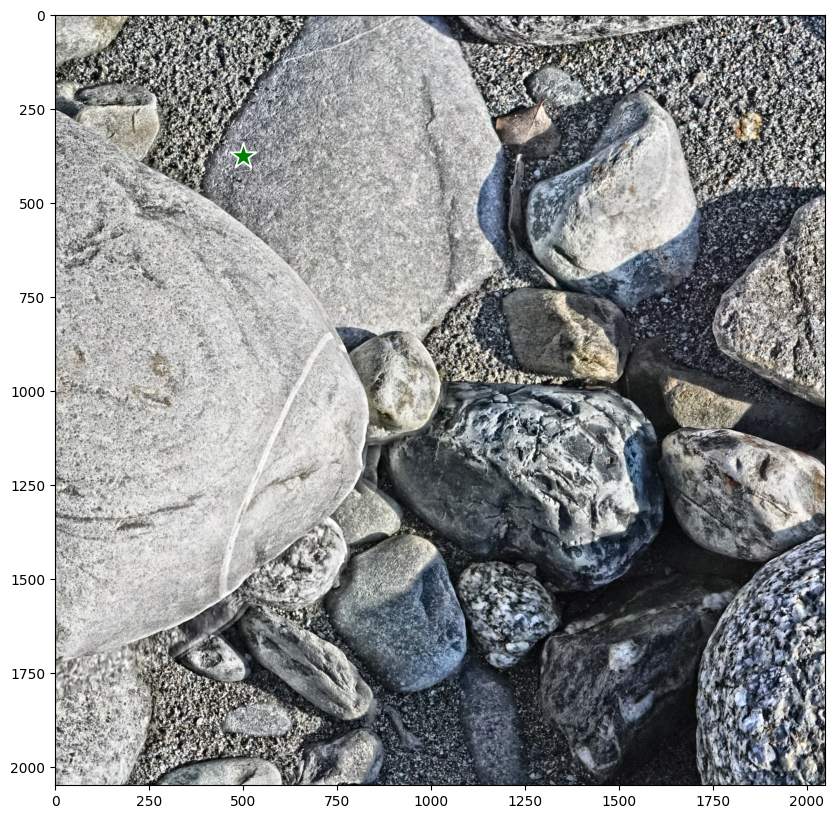

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


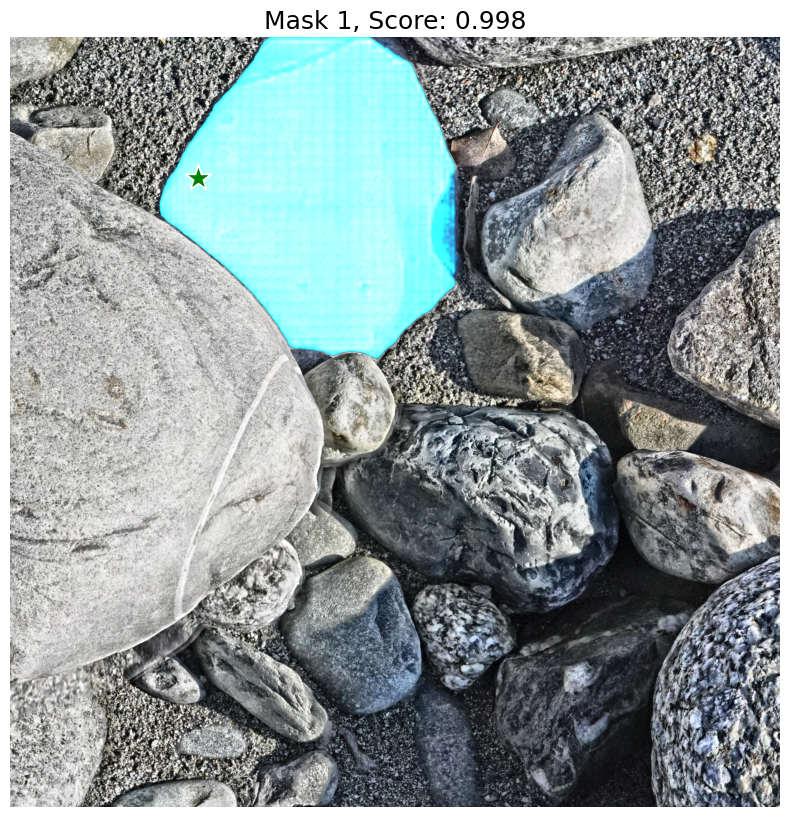

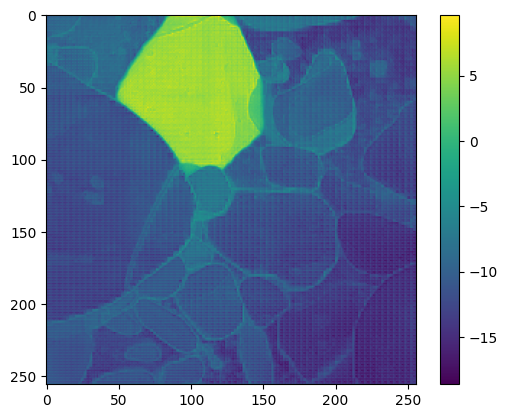

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


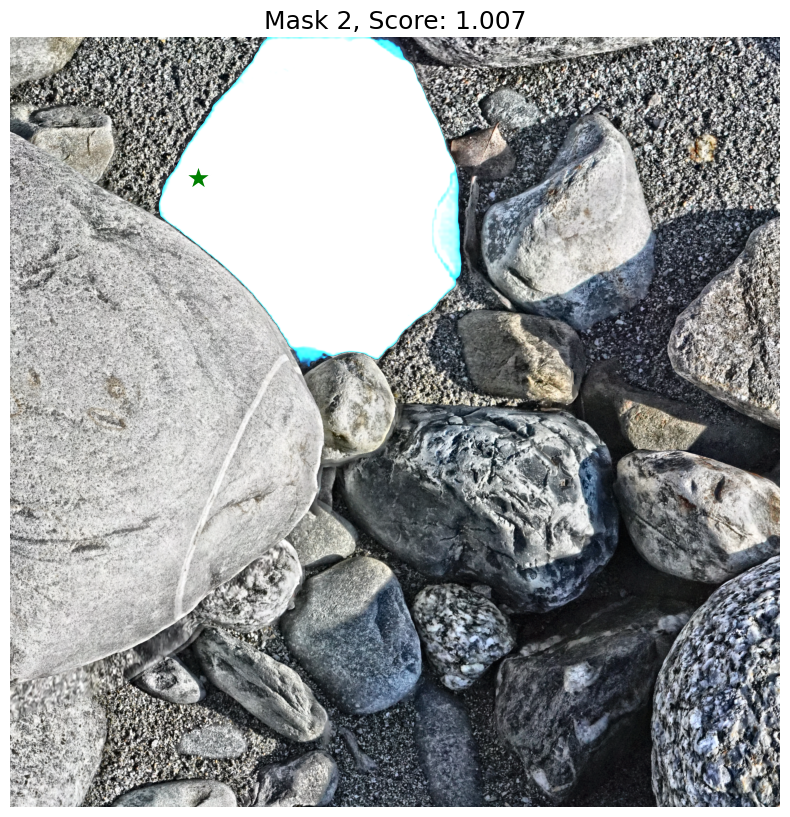

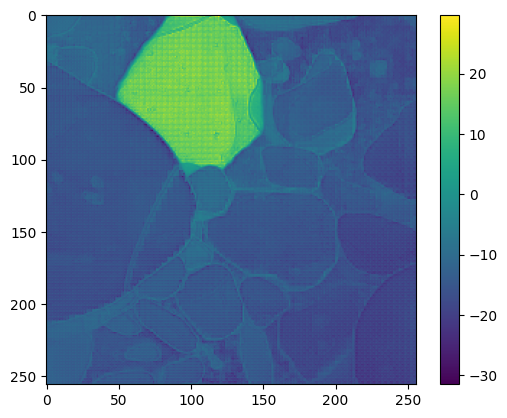

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


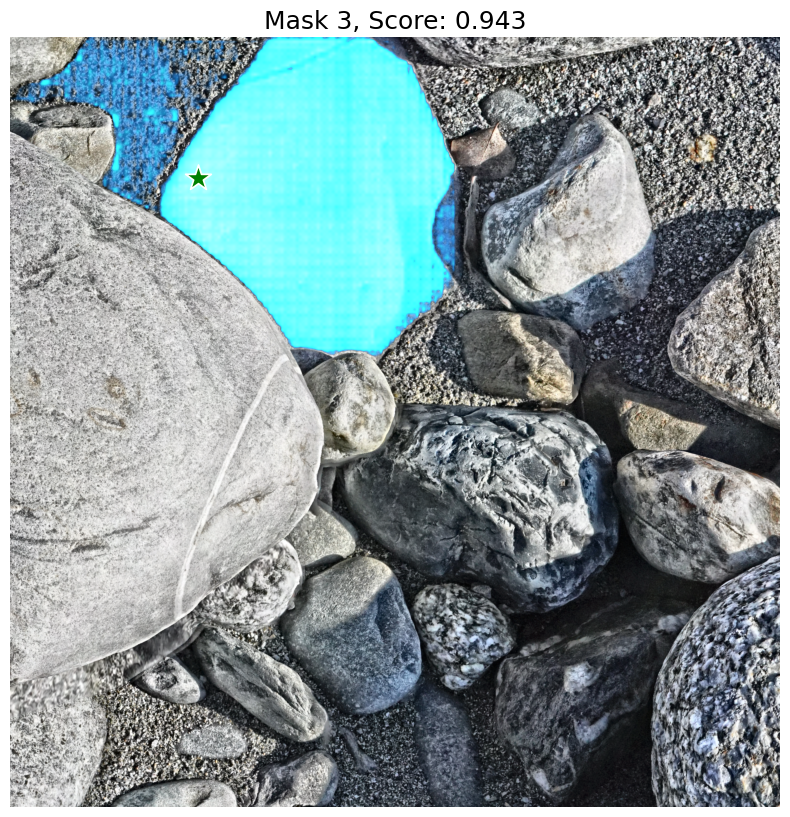

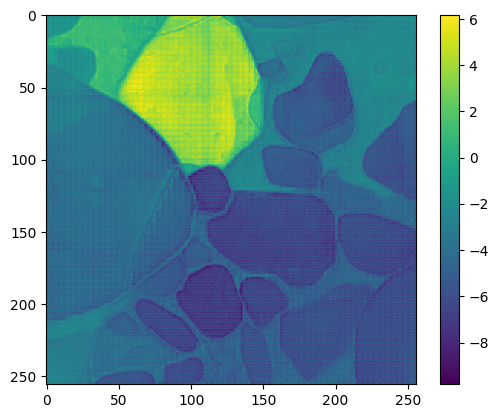

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(temp_image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show() 

for i, (mask, score, logit) in enumerate(zip(masks, scores, logits)):
    plt.figure(figsize=(10,10))
    plt.imshow(temp_image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
    plt.imshow(logit)
    plt.colorbar()
    plt.show()

In [12]:
from typing import Any, Dict, Generator, ItemsView, List, Tuple
def build_point_grid(n_per_side: int) -> np.ndarray:
    """Generates a 2D grid of points evenly spaced in [0,1]x[0,1]."""
    offset = 1 / (2 * n_per_side)
    points_one_side = np.linspace(offset, 1 - offset, n_per_side)
    points_x = np.tile(points_one_side[None, :], (n_per_side, 1))
    points_y = np.tile(points_one_side[:, None], (1, n_per_side))
    points = np.stack([points_x, points_y], axis=-1).reshape(-1, 2)
    return points
def build_all_layer_point_grids(
    n_per_side: int, n_layers: int, scale_per_layer: int
) -> List[np.ndarray]:
    """Generates point grids for all crop layers."""
    points_by_layer = []
    for i in range(n_layers + 1):
        n_points = int(n_per_side / (scale_per_layer**i))
        points_by_layer.append(build_point_grid(n_points))
    return points_by_layer
def batch_iterator(batch_size: int, *args) -> Generator[List[Any], None, None]:
    assert len(args) > 0 and all(
        len(a) == len(args[0]) for a in args
    ), "Batched iteration must have inputs of all the same size."
    n_batches = len(args[0]) // batch_size + int(len(args[0]) % batch_size != 0)
    for b in range(n_batches):
        yield [arg[b * batch_size : (b + 1) * batch_size] for arg in args]
def _process_batch(
        self,
        points: np.ndarray,
        im_size: Tuple[int, ...],
        crop_box: List[int],
        orig_size: Tuple[int, ...],
    ) -> MaskData:
        orig_h, orig_w = orig_size

        # Run model on this batch
        transformed_points = self.predictor.transform.apply_coords(points, im_size)
        in_points = torch.as_tensor(transformed_points, device=self.predictor.device)
        in_labels = torch.ones(in_points.shape[0], dtype=torch.int, device=in_points.device)
        masks, iou_preds, _ = self.predictor.predict_torch(
            in_points[:, None, :],
            in_labels[:, None],
            multimask_output=True,
            return_logits=True,
        )

        # Serialize predictions and store in MaskData
        data = MaskData(
            masks=masks.flatten(0, 1),
            iou_preds=iou_preds.flatten(0, 1),
            points=torch.as_tensor(points.repeat(masks.shape[1], axis=0)),
        )
        del masks

NameError: name 'MaskData' is not defined

In [13]:
points_per_side=12
crop_n_layers=0
crop_n_points_downscale_factor=1
point_grid = build_all_layer_point_grids(
    points_per_side,
    crop_n_layers,
    crop_n_points_downscale_factor,
    )
cropped_im_size = temp_image.shape[:2]
points_scale = np.array(cropped_im_size)[None, ::-1]
points_for_image = point_grid[0] * points_scale

In [14]:
data = MaskData()
for (points,) in batch_iterator(points_per_batch, points_for_image):
    batch_data = _process_batch(points, cropped_im_size, crop_box, orig_size)
    data.cat(batch_data)
    del batch_data

NameError: name 'MaskData' is not defined

In [56]:
len(points_for_image)

144

In [68]:
masks, scores, logits = predictor.predict(
    point_coords=points_for_image,
    point_labels=np.ones(len(points_for_image)),
    multimask_output=True,
    return_logits=False,
)

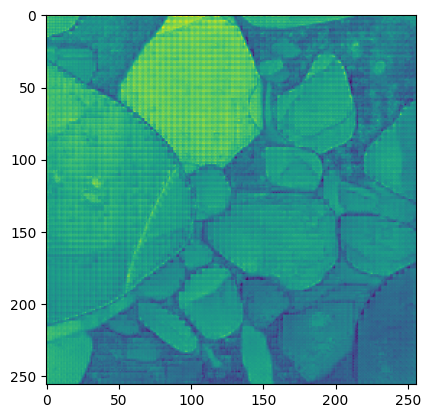

In [69]:
plt.imshow(logits[2])

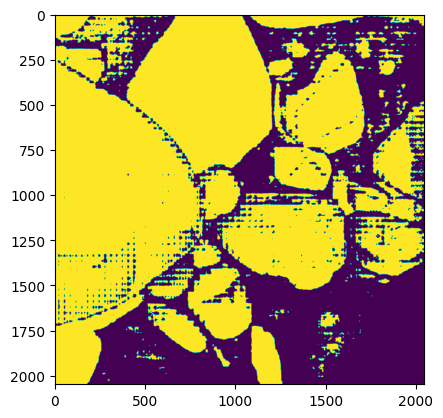

In [70]:
plt.imshow(masks[2])

In [ ]:
class SamAutomaticMaskGenerator:
    def __init__(
        self,
        model: Sam,
        points_per_side: Optional[int] = 32,
        points_per_batch: int = 64,
        pred_iou_thresh: float = 0.88,
        stability_score_thresh: float = 0.95,
        stability_score_offset: float = 1.0,
        box_nms_thresh: float = 0.7,
        crop_n_layers: int = 0,
        crop_nms_thresh: float = 0.7,
        crop_overlap_ratio: float = 512 / 1500,
        crop_n_points_downscale_factor: int = 1,
        point_grids: Optional[List[np.ndarray]] = None,
        min_mask_region_area: int = 0,
        output_mode: str = "binary_mask",
    ) -> None:


        assert (points_per_side is None) != (
            point_grids is None
        ), "Exactly one of points_per_side or point_grid must be provided."
        if points_per_side is not None:
            self.point_grids = build_all_layer_point_grids(
                points_per_side,
                crop_n_layers,
                crop_n_points_downscale_factor,
            )
        elif point_grids is not None:
            self.point_grids = point_grids
        else:
            raise ValueError("Can't have both points_per_side and point_grid be None.")

        assert output_mode in [
            "binary_mask",
            "uncompressed_rle",
            "coco_rle",
        ], f"Unknown output_mode {output_mode}."
        if output_mode == "coco_rle":
            from pycocotools import mask as mask_utils  # type: ignore # noqa: F401

        if min_mask_region_area > 0:
            import cv2  # type: ignore # noqa: F401

AssertionError: MaskData only supports list, numpy arrays, and torch tensors.

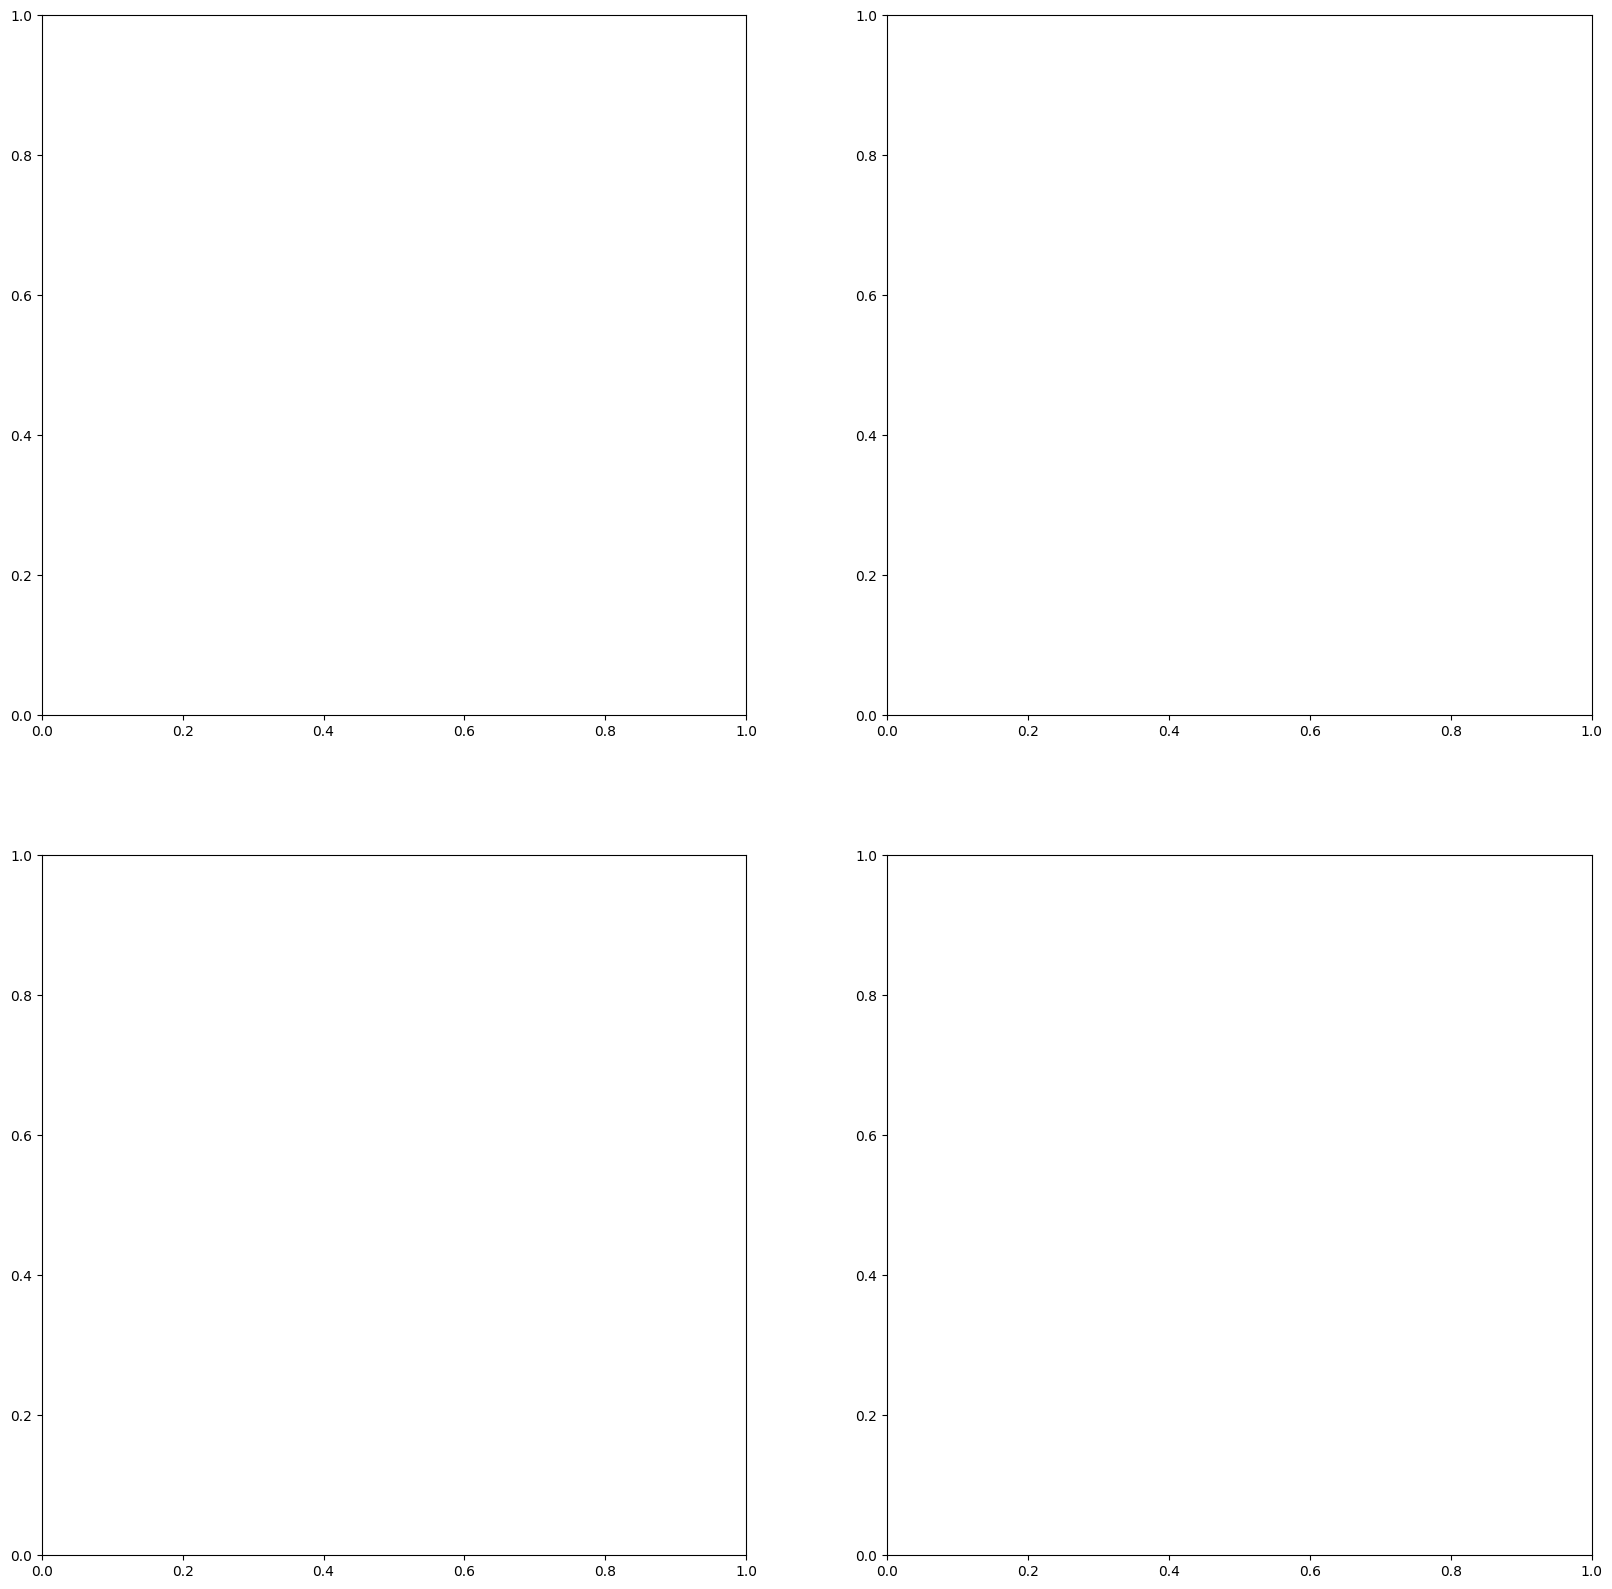

In [7]:
temp_image=fnc.preprocessing_roulette(image, 
                                      {'Crop': {'j':1},
                                       'Gaussian': {'kernel size':3},
                                       'CLAHE':{'clip limit':3}}
                                       )

var='box_nms_thresh'
test=[0.7,1]

fig, ax = plt.subplots(len(test),2,figsize=(20,10*len(test)))
ax=ax.flatten()

#build generator
for i in np.arange(0,len(test),1):
    #refresh memory
    gc.collect()
    torch.cuda.empty_cache()

    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=12,
        pred_iou_thresh=0.9,
        stability_score_thresh=0.95,#iou by varying cutoff in binary conversion
        box_nms_thresh=test[i],#The box IoU cutoff used by non-maximal suppression to filter duplicate masks
        crop_n_layers=0,#cut into 2**n crops
        crop_nms_thresh=0,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks between crops
        crop_n_points_downscale_factor=1,
        crop_overlap_ratio=0,
        min_mask_region_area=2000,
    )
    with torch.no_grad():
        masks = mask_generator.generate(temp_image)
    ax[i*2].imshow(temp_image)
    fnc.show_anns_mod_ax(masks, ax[i*2])
    ax[i*2].set_title(f'{var}: {test[i]} Number of masks: {len(masks)}')
    ax[i*2].axis('off')
    list_of_masks = [mask['segmentation'].astype(np.uint8) for mask in masks]
    ar_masks=np.stack(list_of_masks) 
    ax[i*2+1].imshow(np.sum(ar_masks,axis=0))
    ax[i*2+1].set_title(f'Max overlap: {np.unique(np.sum(ar_masks,axis=0)).max()}')       
plt.tight_layout()
plt.show()

In [8]:
gc.collect()
torch.cuda.empty_cache()

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=12,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.95,#iou by varying cutoff in binary conversion
    box_nms_thresh=0.3,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks
    crop_n_layers=0,#cut into 2**n crops
    crop_nms_thresh=0,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks between crops
    crop_n_points_downscale_factor=1,
    crop_overlap_ratio=0,
    #min_mask_region_area=2000,
)
with torch.no_grad():
    masks = mask_generator.generate(temp_image)

AssertionError: MaskData only supports list, numpy arrays, and torch tensors.

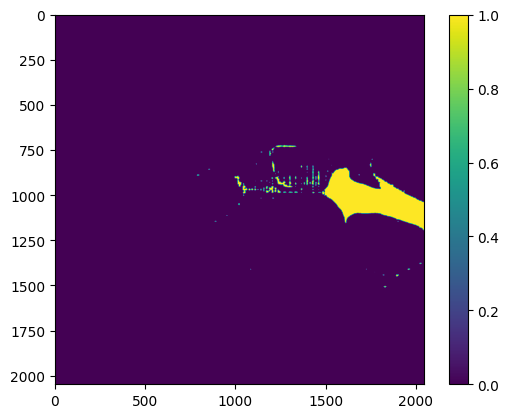

In [25]:
plt.imshow(masks[100]['segmentation'])
plt.colorbar()

In [18]:
print(masks[100]['stability_score'])
print(masks[100]['predicted_iou'])
print(masks[100]['point_coords'])

0.9666284322738647
0.9833649396896362
[[1621.3333333333335, 938.6666666666669]]


In [19]:
np.unique(masks[100]['segmentation'])

array([-31.428692, -31.321327, -31.18328 , ...,  21.657158,  21.754547,
        21.909466], dtype=float32)